From the paper we aim to reproduce and extend, we learn that the BKF MAP estimator is equivalent to universal soft thresholding, given the following condtions
- $\frac{\sigma_{\theta}^2}{c} = log N$ 
- $\alpha \to 1$
or large $N$.

In [1]:
import numpy as np
import pywt

def universal_soft_thresholding(image, wavelet='db4', level=1, mode='periodization'):
    # 2D wavelet decomposition
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level, mode=mode)

    # --- Estimate sigma from finest-level HH band (cD1) ---
    cH1, cV1, cD1 = coeffs[-1]
    sigma = np.median(np.abs(cD1)) / 0.6745
    sigma = max(sigma, 1e-10)  # avoid zero sigma

    def soft(c, T):
        return np.sign(c) * np.maximum(np.abs(c) - T, 0)

    # new coeff list, copy approximation
    new_coeffs = [coeffs[0]]

    # apply thresholding at each level
    for (cH, cV, cD) in coeffs[1:]:
        # band-size dependent universal threshold
        N_band = cH.size + cV.size + cD.size   
        T = sigma * np.sqrt(2 * np.log(N_band))

        cH_t = soft(cH, T)
        cV_t = soft(cV, T)
        cD_t = soft(cD, T)

        new_coeffs.append((cH_t, cV_t, cD_t))

    # reconstruct
    denoised = pywt.waverec2(new_coeffs, wavelet=wavelet, mode=mode)
    return denoised


In [2]:
#now need a function to run universal_soft_thresholding using db4, sym4, and coif4 wavelets
def run_thresholding_with_wavelets(data, wavelets=['db4', 'sym4', 'coif4'], level=1):
    results = {}
    for wavelet in wavelets:
        denoised_data = universal_soft_thresholding(data, wavelet=wavelet, level=level)
        results[wavelet] = denoised_data
    return results


In [3]:
#COPYING A BUNCH OF FUNCTIONS FROM BKFALGORITHMS 
def add_noise(img, SNR_dB, noise_type='gaussian'):
    signal_power = np.mean(img ** 2)
    noise_power = signal_power / (10 ** (SNR_dB / 10))
    if noise_type == 'poisson':
      lamda = np.power(10,SNR_dB/10)/np.mean(img)
      scaled = img * lamda
      noisy_counts = np.random.poisson(scaled)
      noisy = noisy_counts / lamda
    else:
        noise = np.random.normal(0, np.sqrt(noise_power), img.shape)
        noisy = img + noise
    return np.clip(noisy, 0, 1)
def estimate_SNR(img, estim_std):
     signal_power = np.mean(img ** 2)
     estim_SNR = 10 * np.log10(signal_power / (estim_std ** 2))
     return estim_SNR
print("Meow")
def get_dHH1_subband(noisy_image, wavelet_name='db4'):

    coeffs = pywt.wavedec2(noisy_image, wavelet=wavelet_name, level=1)
    # Unpack the detail coefficients from the tuple
    cA, (cH1, cV1, dHH_1) = coeffs
    
    return dHH_1


def estimate_noise_std(noisy_image, wavelet_name='db4'):
    # extract dHH_1 subband 
    dHH_1 = get_dHH1_subband(noisy_image, wavelet_name=wavelet_name)
    #dHH_1 = dHH_1 / np.max(np.abs(dHH_1))  # normalize to [-1,1]
    #calculate MAD, we can take this shortcut bc awgn so we assume median is approx 0.
    mad_val = np.median(np.abs(dHH_1))
    #compute sigma_epsilon 
    sigma_epsilon = mad_val / 0.6745
    return sigma_epsilon



Meow


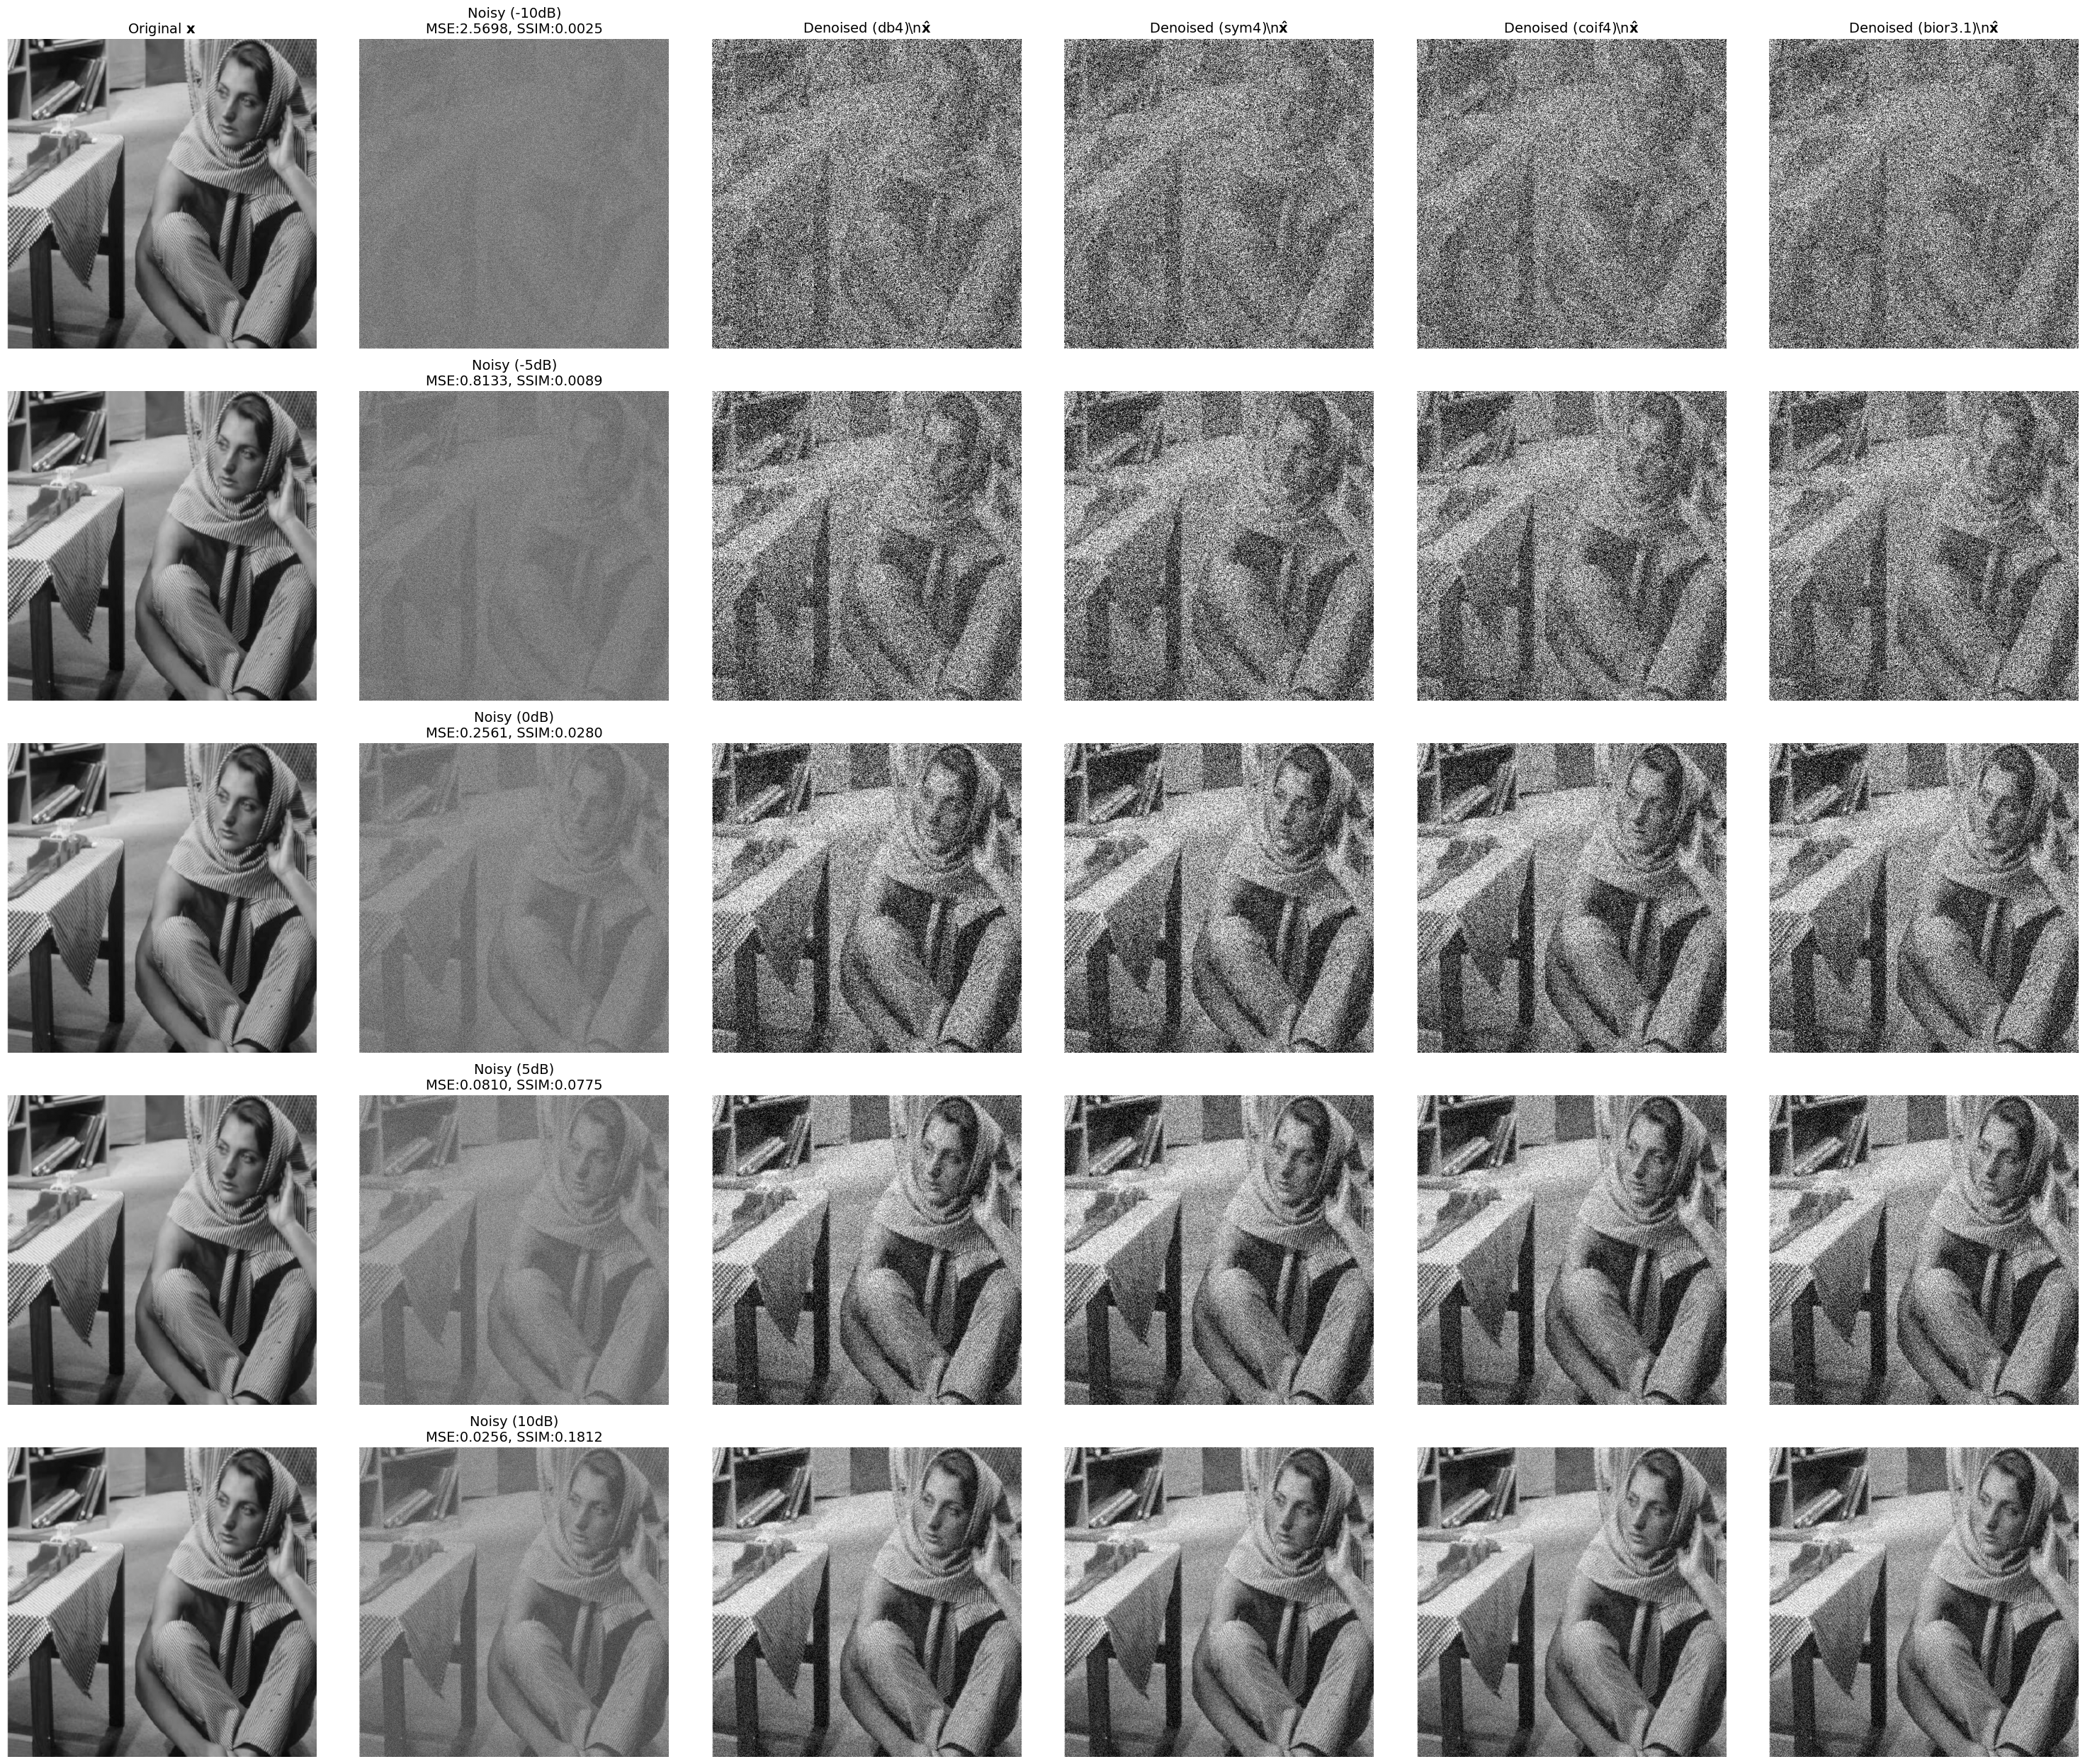


--- Summary of Denoising Metrics (Including Noisy Baseline) ---
--------------------------------------------------

## Mean Squared Error (MSE) Results
Metrics (Columns): ['Noisy', 'db4', 'sym4', 'coif4', 'bior3.1']
--------------------------------------------------
SNR_dB Rows:
  -10 dB: [2.5698 0.2189 0.2184 0.2196 0.2208]
  -5 dB: [0.8133 0.1531 0.1513 0.152  0.1593]
  0 dB: [0.2561 0.068  0.0665 0.0669 0.0816]
  5 dB: [0.081  0.0203 0.0201 0.0201 0.03  ]
  10 dB: [0.0256 0.0066 0.0065 0.0065 0.0104]

## Structural Similarity Index Measure (SSIM) Results
Metrics (Columns): ['Noisy', 'db4', 'sym4', 'coif4', 'bior3.1']
--------------------------------------------------
SNR_dB Rows:
  -10 dB: [0.0025 0.0133 0.0135 0.0135 0.0133]
  -5 dB: [0.0089 0.0283 0.0288 0.0292 0.0267]
  0 dB: [0.028  0.0777 0.0795 0.0798 0.0636]
  5 dB: [0.0775 0.2076 0.2091 0.2112 0.1546]
  10 dB: [0.1812 0.3892 0.3919 0.3938 0.3031]


In [ ]:
from skimage import io, util, img_as_float
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error, structural_similarity 
import matplotlib.pyplot as plt
import numpy as np

img = img_as_float(io.imread("barbara.png"))

if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3] 

gray_img = rgb2gray(img)

print(f"Image shape: {gray_img.shape}")

SNR_dB_values = [-10, -5, 0, 5, 10]

num_wavelets = 4 
total_cols = num_wavelets + 1 
all_mse_results = np.zeros((len(SNR_dB_values), total_cols))
all_ssim_results = np.zeros((len(SNR_dB_values), total_cols))
wavelet_titles = ['db4', 'sym4', 'coif4', 'bior3.1']
summary_titles = ['Noisy Image'] + wavelet_titles 

print("\nStarting noise addition and denoising...\n")

for snr_idx, SNR_dB in enumerate(SNR_dB_values):
    noisy_img = add_noise(gray_img, SNR_dB, 'gaussian')
    
    original_std = round(estimate_noise_std(gray_img), 4)
    noisy_std = round(estimate_noise_std(noisy_img), 4)
    
    noisy_mse = round(mean_squared_error(gray_img, noisy_img), 4)
    noisy_ssim = round(structural_similarity(gray_img, noisy_img, data_range=1.0), 4)
    
    all_mse_results[snr_idx, 0] = noisy_mse
    all_ssim_results[snr_idx, 0] = noisy_ssim
    
    denoised_results = run_thresholding_with_wavelets(noisy_img, wavelets=wavelet_titles, level=1)

    fig, axes = plt.subplots(1, 6, figsize=(25, 5)) 
    
    axes[0].imshow(gray_img, cmap='gray')
    axes[0].set_title(f'Original\nEstimated STD: {original_std}')
    axes[0].axis('off')
    
    axes[1].imshow(noisy_img, cmap='gray')
    axes[1].set_title(f'Noisy (SNR: {SNR_dB} dB)\nSTD: {noisy_std}\nMSE: {noisy_mse}, SSIM: {noisy_ssim}')
    axes[1].axis('off')

    for i, wavelet in enumerate(wavelet_titles):
        denoised_img = denoised_results[wavelet]
        
        denoised_mse = round(mean_squared_error(gray_img, denoised_img), 4)
        denoised_ssim = round(structural_similarity(gray_img, denoised_img, data_range=1.0), 4)
        
        all_mse_results[snr_idx, i + 1] = denoised_mse
        all_ssim_results[snr_idx, i + 1] = denoised_ssim
        
        denoised_std = round(estimate_noise_std(denoised_img), 4)
        axes[i + 2].imshow(denoised_img, cmap='gray')
        axes[i + 2].set_title(f'{wavelet} Denoised\nSTD: {denoised_std}\nMSE: {denoised_mse}, SSIM: {denoised_ssim}')
        axes[i + 2].axis('off')
        
    plt.suptitle(f'Denoising Results for SNR = {SNR_dB} dB', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

print("\n--- Summary of Denoising Metrics (Including Noisy Baseline) ---")

print("\n## Mean Squared Error (MSE) Results")
print(f"Metrics (Columns): {summary_titles}")
print("-" * 50)
print("SNR_dB Rows:")
for idx, snr in enumerate(SNR_dB_values):
    print(f"  {snr} dB: {np.round(all_mse_results[idx, :], 4)}")

print("\n## Structural Similarity Index Measure (SSIM) Results")
print(f"Metrics (Columns): {summary_titles}")
print("-" * 50)
print("SNR_dB Rows:")
for idx, snr in enumerate(SNR_dB_values):
    print(f"  {snr} dB: {np.round(all_ssim_results[idx, :], 4)}")